<a href="https://colab.research.google.com/github/sergiomora03/AdvancedTopicsAnalytics/blob/main/notebooks/L15-Headline_Generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Generador de titulares

### Objetivos
* Preparar datos secuenciales para usar en una [red neuronal recurrente](https://developers.google.com/machine-learning/glossary#recurrent-neural-network) (RNN)
* Construir y entrenar un modelo que realice predicción de texto.

### Generador de titulares
Los predictores de texto están presentes en numerosas aplicaciones conocidas como barras de búsqueda, celulares o editores de texto que ofrecen la función de autocompletar oraciones. Muchos de los buenos modelos de predicción de texto son entrenados utilizando bases de datos muy grandes, lo cual toma mucho tiempo y/o poder de procesamiento. Para este ejercicio, nuestro predictor será bastante simple, pero proveerá una exposición simple para el procesamiento de lenguaje, secuencias de datos y uno de los elementos de arquitectura clásicos usados para entrenar secuencias, las *redes neuronales recurrentes* o *RNNs*.

## Lectura de los datos
Nuestra base de datos consiste de titulares del periódico [New York Times](https://www.nytimes.com/) durante el transcurso de varios meses. Empezaremos leyendo todos los titulares de los artículos, los cuales están en formato `.csv`. Utilizaremos `pandas` para importar esta información; para esto, puede crear una carpeta llamada `nyt_dataset` y subir los archivos en esta, o puede subir los archivos en su drive/carpeta de preferencia y cambiar la dirección en la variable `nyt_dir`:

In [17]:
# from zipfile import ZipFile
# with ZipFile('nyt_dataset.zip', 'r') as nyt:
#   nyt.extractall('nyt_dataset')

In [21]:
import os
import pandas as pd

nyt_dir = 'nyt_dataset/nyt_dataset/'

all_headlines = []
for filename in os.listdir(nyt_dir):
    if 'Articles' in filename:
        # Se leen todos los datos del archivo CSV
        headlines_df = pd.read_csv(nyt_dir + filename)
        # Y todos los titulares a nuestra lista
        all_headlines.extend(list(headlines_df.headline.values))
len(all_headlines)

9335

Veamos los primeros titulares de la base de datos:

In [22]:
all_headlines[:20]

['Finding an Expansive View  of a Forgotten People in Niger',
 'And Now,  the Dreaded Trump Curse',
 'Venezuela’s Descent Into Dictatorship',
 'Stain Permeates Basketball Blue Blood',
 'Taking Things for Granted',
 'The Caged Beast Awakens',
 'An Ever-Unfolding Story',
 'O’Reilly Thrives as Settlements Add Up',
 'Mouse Infestation',
 'Divide in G.O.P. Now Threatens Trump Tax Plan',
 'Variety Puzzle: Acrostic',
 'They Can Hit a Ball 400 Feet. But Play Catch? That’s Tricky.',
 'In Trump Country, Shock at Trump Budget Cuts',
 'Why Is This Hate Different From All Other Hate?',
 'Pick Your Favorite Ethical Offender',
 'My Son’s Growing Black Pride',
 'Jerks and the Start-Ups They Ruin',
 'Trump  Needs  a Brain',
 'Manhood in the Age of Trump',
 'The Value of a Black College']

## Limpieza de los datos

Para asegurar la calidad de los datos de entrenamiento, eliminaremos algunos titulares que están listados como "Unknown"_

In [23]:
all_headlines = [h for h in all_headlines if h != "Unknown"]
len(all_headlines)

8603

Veamos como quedan los datos ahora:

In [24]:
all_headlines[:20]

['Finding an Expansive View  of a Forgotten People in Niger',
 'And Now,  the Dreaded Trump Curse',
 'Venezuela’s Descent Into Dictatorship',
 'Stain Permeates Basketball Blue Blood',
 'Taking Things for Granted',
 'The Caged Beast Awakens',
 'An Ever-Unfolding Story',
 'O’Reilly Thrives as Settlements Add Up',
 'Mouse Infestation',
 'Divide in G.O.P. Now Threatens Trump Tax Plan',
 'Variety Puzzle: Acrostic',
 'They Can Hit a Ball 400 Feet. But Play Catch? That’s Tricky.',
 'In Trump Country, Shock at Trump Budget Cuts',
 'Why Is This Hate Different From All Other Hate?',
 'Pick Your Favorite Ethical Offender',
 'My Son’s Growing Black Pride',
 'Jerks and the Start-Ups They Ruin',
 'Trump  Needs  a Brain',
 'Manhood in the Age of Trump',
 'The Value of a Black College']

Generalmente, se remueve la puntuación y se convierten todas las letras en minúsculas para facilitar el entrenamiento del modelo. Para nuestros propósitos, hay poca o ninguna diferencia entre una línea terminando con "!" o "?" o si una palabra tiene una mayúscula inicial, como en "The", o minúscula, como en "the". Simplificar esta información nos ayuda a reducir la cantidad de tokens únicos y hará que el modelo sea más fácil de entrenar. Nosotros podríamos filtrar las oraciones antes de la tokenización, sin embargo, no necesitamos realizarla como un proceso aparte pues la función `Tokenizer` de Keras ya la tiene integrada.

## Tokenización
Este proceso permite representar las palabras de cada titular de una manera que el modelo sea capaz de entender. La tokenización separa un texto en pequeñas partes (tokens), en este caso, las palabras. Cada palabra única es asociada a un número, de manera que el modelo es capaz de procesar la información. Keras tiene una función que nos ayuda a tokenizar los datos:
```python
tf.keras.preprocessing.text.Tokenizer(
    num_words=None, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True,
    split=' ', char_level=False, oov_token=None, document_count=0, **kwargs
)
```
Al observar la función [Tokenizer](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer) en Keras, vemos que los valores por defecto ya están establecidos para nuestro caso. La variable string `filters` remueve la puntuación y convierte todas las letras a minúsculas:

In [25]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_headlines)
print('Total words: ', len(tokenizer.word_index))

Total words:  11752


Miremos el diccionario `word_index` para detallar cómo el tokenizador guarda las palabras:

In [26]:
# Se imprime un subconjunto del diccionario word_index creado por Tokenizer
subset_dict = {key: value for key, value in tokenizer.word_index.items() \
               if key in ['a','man','a','plan','a','canal','panama']}
print(subset_dict)

{'a': 2, 'plan': 82, 'man': 138, 'panama': 3127, 'canal': 7839}


Podemos utilizar el método `texts_to_sequences` para ver los índices de una palabra de interés:

In [27]:
tokenizer.texts_to_sequences(['a','man','a','plan','a','canal','panama'])

[[2], [138], [2], [82], [2], [7839], [3127]]

## Creación de secuencias

Luego de tokenizar los datos, crearemos secuencias de tokens para los titulares, los cuales serán utilizados para el entrenamiento de nuestro modelo de Deep Learning. Por ejemplo, si tenemos el titular _"nvidia launches ray tracing gpus"_, cada palabra será reemplazada por el número correspondiente, supongamos: nvidia - 5, launches - 22, ray - 94, tracing - 16, gpus - 102, entonces la secuencia completa sería [5, 22, 94, 16, 102]. También es útil entrenar sobre secuencias más pequeñas que estén dentro del titular, como "nvidia launches".

A continuación, tomaremos cada titular y crearemos un conjunto de secuencias ampliando nuestro dataset al incluir secuencias parciales:



In [28]:
input_sequences = []
for line in all_headlines:
    # Se convierte el titular en una secuencia de tokens
    token_list = tokenizer.texts_to_sequences([line])[0]

    # Se crea una serie de secuencias para cada titular
    for i in range(1, len(token_list)):
        partial_sequence = token_list[:i+1]
        input_sequences.append(partial_sequence)

print(tokenizer.sequences_to_texts(input_sequences[:5]))
input_sequences[:5]

['finding an', 'finding an expansive', 'finding an expansive view', 'finding an expansive view of', 'finding an expansive view of a']


[[403, 17],
 [403, 17, 5242],
 [403, 17, 5242, 543],
 [403, 17, 5242, 543, 4],
 [403, 17, 5242, 543, 4, 2]]

## Aplicando padding a las secuencias

En este momento, nuestras secuencias tienen diferente longitud. Para que nuestro modelo pueda ser entrenado a partir de estos datos es necesario hacer que todas las secuencias tengan la misma longitud. Esto se puede realizar aplicando _padding_ a cada secuencia, esto es, agregar ceros hasta que la longitud de todas las secuencias coincida con la de la secuencia de máxima longitud.

Keras ya posee un método que realiza esta operación, conocida como [`pad_sequences`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences):

In [29]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Se determina la longitud máxima de todas las secuencias
max_sequence_len = max([len(x) for x in input_sequences])

# Se aplica padding a todas las secuencias con ceros en el inicio para hacerlos todos del mismo tamaño
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))
input_sequences[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
       403,  17], dtype=int32)

## Dividiendo entre predictores y objetivos

Ahora, queremos dividir nuestras secuencias en predictores y un objetivo. La última palabra de la secuencia, la cual se quiere predecir, será el objetivo, mientras que las primeras palabras de la secuencia serán los predictores. A modo de ejemplo, miremos el titular. _"nvidia releases ampere graphics cards"_:

<table>
<tr><td>PREDICTORS </td> <td>           TARGET </td></tr>
<tr><td>nvidia                   </td> <td>  releases </td></tr>
<tr><td>nvidia releases               </td> <td>  ampere </td></tr>
<tr><td>nvidia releases ampere      </td> <td>  graphics</td></tr>
<tr><td>nvidia releases ampere graphics </td> <td>  cards</td></tr>
</table>

In [30]:
# Los predictores son todas las palabras excepto la última
predictors = input_sequences[:,:-1]
# Los objetivos (labels) son la última palabra
labels = input_sequences[:,-1]
labels[:5]

array([  17, 5242,  543,    4,    2], dtype=int32)

Nuestros objetivos son variables categóricas, ya que estamos prediciendo una palabra de nuestro vocabulario particular. Una estrategia útil es reemplazar la predicción de números escalares por categorías binarias, donde tenemos un vector de 0's de longitud igual a la cantidad de palabras de nuestro vocabulario (`total_words`), excepto por una posición que tendrá el valor de 1. Esta posición está definida por el token de la palabra. Esta conversión se puede realizar con la ayuda de Keras:

In [31]:
from tensorflow.keras import utils
total_words = len(tokenizer.word_index) + 1 #El padding agrega un cero a la cantidad total de palabras que debe ser considerado
labels = utils.to_categorical(labels, num_classes=total_words)
labels[:2]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

Note que la segunda palabra tiene un token igual a 1, así que su label será igual a un vector de 0's excepto en la posición 1.

## Creando el modelo

Para nuestro modelo, explicaremos dos capas para plantear nuestro modelo de red neuronal recurrente.

### [Embedding Layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding)

La capa de _embedding_ es la primera de la red y se plantea de la siguiente forma::

```Python
model.add(Embedding(input_dimension, output_dimension, input_length=input_len))
```

Esta capa tomará las secuencias tokenizadas y aprenderá una codificación o _embedding_ para todas las palabras del dataset de entrenamiento. Matemáticamente, los _embeddings_ trabajan de la misma forma que una neurona en una red neuronal, pero conceptualmente, su objetivo es reducir el número de dimensiones para algunas o todas las características (_features_). En este caso, la capa representará cada palabra como un vector y la información dentro de ese vector contendrá las relaciones entre cada palabra. La dimensión del embedding (`output_dimension`) establece el tamaño de la vectorización, por lo que tenemos un hiperparámetro que puede requerir calibracion.

### [Long Short Term Memory Layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM)

Esta es la capa más importante ya que aquí establecemos la arquitectura básica de nuestra red neuronal recurrente (RNN). En este notebook, utilizaremos la arquitectura _Long Short Term Memory_ (LSTM). A diferencia de las redes tracionales _feed-forward_, las redes recurrentes se retroalimentan a ellas mismas, permitiendo que la información persista. El concepto básico de una RNN se puede representar así:

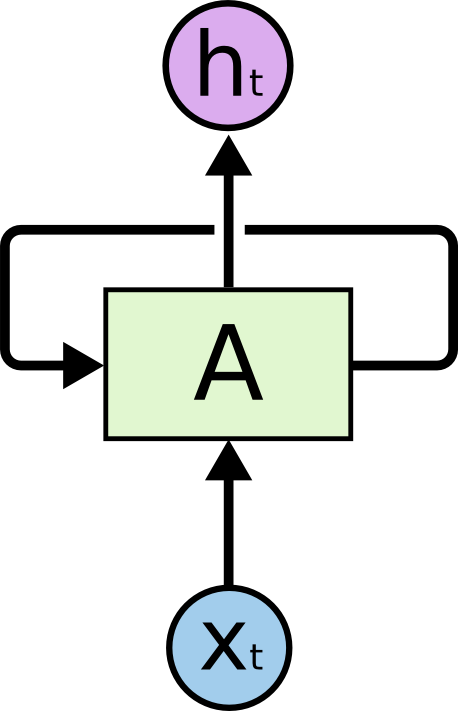

En este esquema, nueva información $X_t$ es pasada a la red, la cual entrega una predicción $h_t$. Adicionalmente, la información que sale de esa capa es guardada y usada como entrada/_input_ para la siguiente predicción. Esto puede parecer complicado, pero si expandimos el bucle de la red neuronal, podemos entender la intuición detrás de esta red:

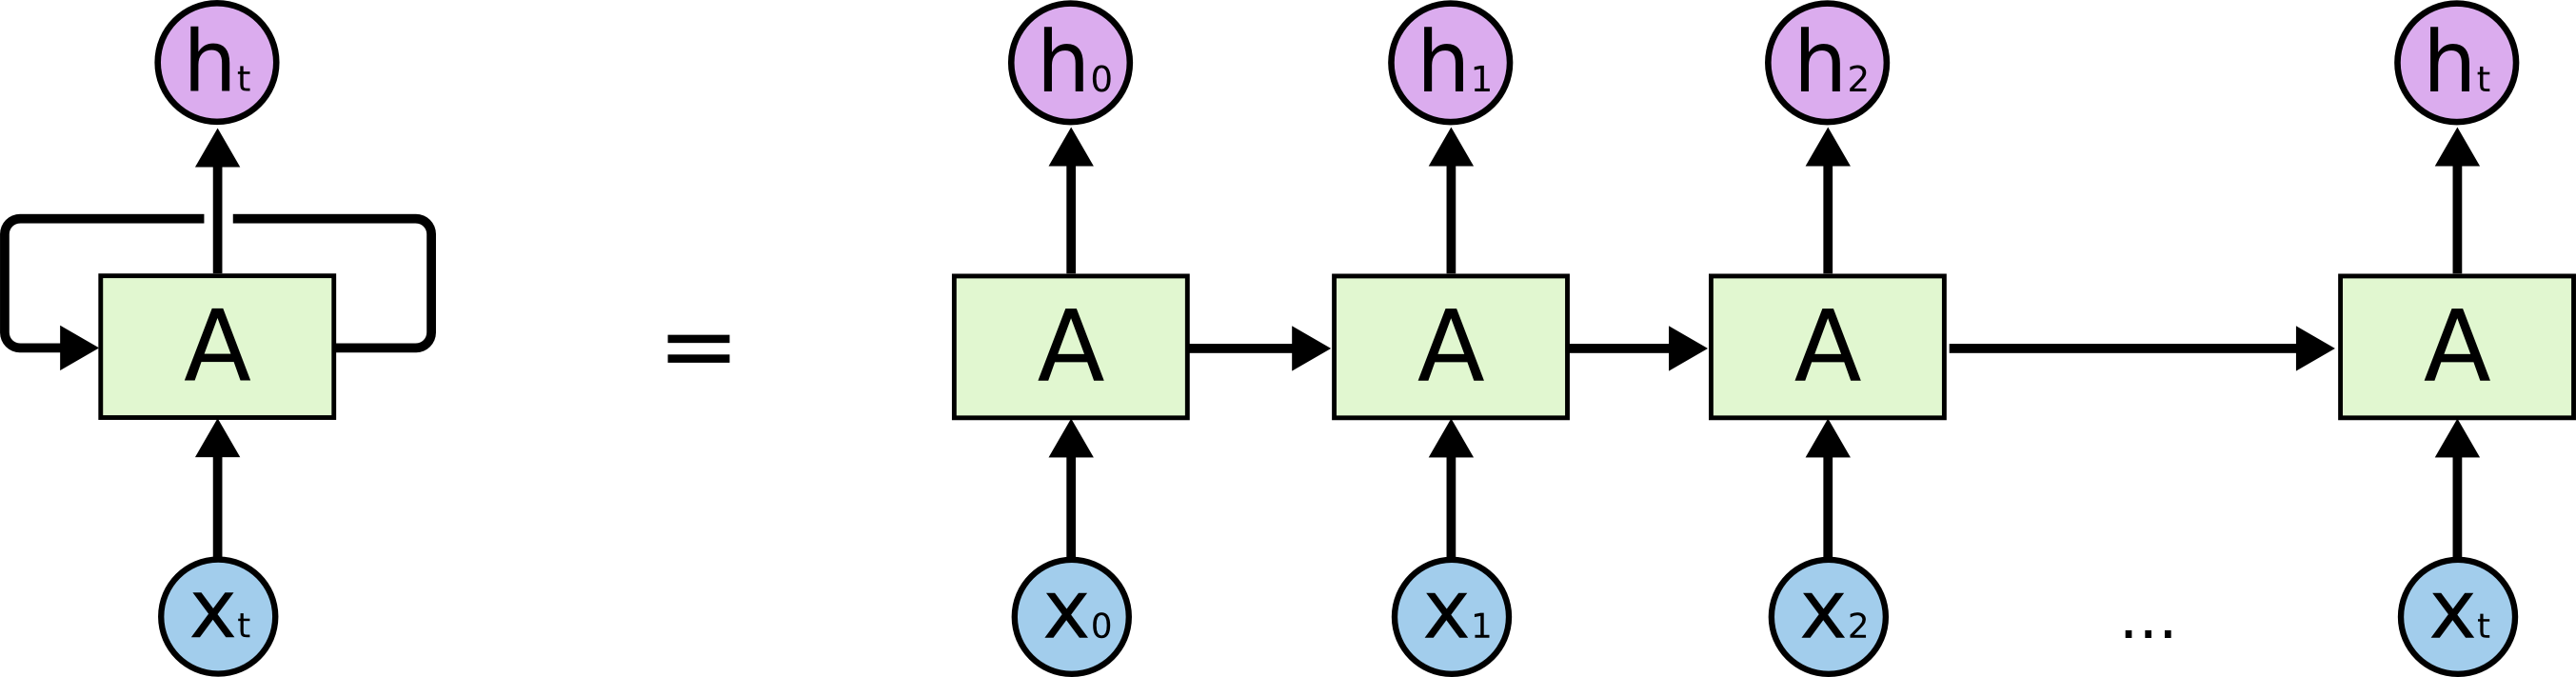

Podemos ver que la red A no sólo recibe el dato $X_1$, por ejemplo, sino que también la predicción del dato anterior $h_0$, generando un resultado $h_1$ que será utilizado para la siguiente predicción.

Estas RNNs tradicionales sufre del problema de que la información reciente contribuye más en una predicción que la que está más en el pasado. Redes del tipo LSTM son una arquitectura especial que son capaces de aprender y retener información de largo plazo. Para mayor información sobre estos tipos de redes, recomendamos [este artículo](https://colah.github.io/posts/2015-08-Understanding-LSTMs/).

Ahora, creemos nuestro modelo. Nótese que las unidades LSTM se establecen de igual forma que el número de neuronas en una red tradicional; acá probaremos 100 unidades, pero es un hiperparámetro que se requiere calibrar. También, se agregó una capa de Dropout con probabilidad de 0.1, valor que se puede calibrar según la cantidad de pesos que se quieran establecer en 0 para evitar overfitting.

In [32]:
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential

# Se remueve la última palabra para el cálculo de la longitud del input pues se usó para el label
input_len = max_sequence_len - 1

#Tamaño del embedding
embedding_dim = 10

model = Sequential()
# Se agrega capa de embedding
model.add(Embedding(total_words,embedding_dim,input_length=input_len))

# Se agrega capa LSTM layer with 100 units
model.add(LSTM(100))
# Se agrega capa de dropout
model.add(Dropout(0.1))

# Se agrega capa de salida con función de activación softmax
model.add(Dense(total_words, activation='softmax'))

In [33]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 27, 10)            117530    
                                                                 
 lstm (LSTM)                 (None, 100)               44400     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 11753)             1187053   
                                                                 
Total params: 1,348,983
Trainable params: 1,348,983
Non-trainable params: 0
_________________________________________________________________


## Compilando el modelo

Compilamos nuestro modelo utilizando la función de pérdida _categorical crossentropy_, la cual nos permite evaluar la predicción de una palabra con respecto al vocabulario total. En este caso, vamos a utilizar el _accuracy_ como métrica ya que la predicción de texto no se puede medir fácilmente como más o menos exacta en la misma forma que se hace en otros contextos.

Adicionalmente, seleccionaremos un optimizador particular que es apropiado para arquitecturas LSTM, conocido como _Adam_. Los detalles sobre estos optimizadores están fuera del alcance de este curso, pero es importante saber que hay diferentes optimizadores que pueden desempeñarse mejor para ciertas tareas de deep learning. Se puede leer más sobre estas, incluyendo el optimizador Adam, [aquí](https://medium.com/datadriveninvestor/overview-of-different-optimizers-for-neural-networks-e0ed119440c3).

In [34]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

## Entrenamiento del modelo
A continuación, entrenaremos nuestro modelo por 30 épocas, lo cual tomará pocos minutos gracias al uso de GPU. Nótese que no tenemos _accuracy_ de entrenamiento ni de validación; es más, no hemos realizado una división entre conjunto de datos de entrenamiento, validación y prueba (_test_). Esto refleja que la predicción de texto sigue un paradigma distinto de deep learning respecto a otras aplicaciones.

In [35]:
history = model.fit(predictors, labels, epochs=30, verbose=1)

Epoch 1/30
1666/1666 [==============================] - 35s 15ms/step - loss: 7.8834
Epoch 2/30
1666/1666 [==============================] - 12s 7ms/step - loss: 7.4767
Epoch 3/30
1666/1666 [==============================] - 11s 7ms/step - loss: 7.2817
Epoch 4/30
1666/1666 [==============================] - 11s 7ms/step - loss: 7.0615
Epoch 5/30
1666/1666 [==============================] - 12s 7ms/step - loss: 6.8269
Epoch 6/30
1666/1666 [==============================] - 11s 7ms/step - loss: 6.5753
Epoch 7/30
1666/1666 [==============================] - 11s 7ms/step - loss: 6.3161
Epoch 8/30
1666/1666 [==============================] - 11s 7ms/step - loss: 6.0664
Epoch 9/30
1666/1666 [==============================] - 12s 7ms/step - loss: 5.8228
Epoch 10/30
1666/1666 [==============================] - 11s 7ms/step - loss: 5.5946
Epoch 11/30
1666/1666 [==============================] - 11s 7ms/step - loss: 5.3741
Epoch 12/30
1666/1666 [==============================] - 11s 7ms/step - l

Grafiquemos la evolución de la función de pérdida:

Text(0, 0.5, 'loss')

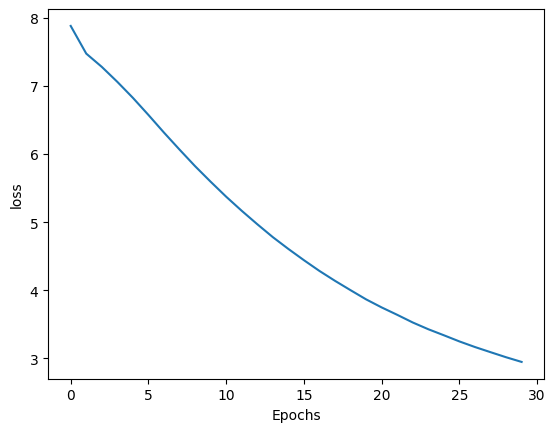

In [36]:
from matplotlib import pyplot as plt
plt.plot(history.history['loss'])
plt.xlabel("Epochs")
plt.ylabel('loss')

## Discusión de resultados
Podemos ver que la función de pérdida ha decrecido durante el entrenamiento. Nosotros podríamos entrenar el modelo durante más épocas para decrecer la función de pérdida, lo cual nos tomaría más tiempo. Por el momento, intentemos realizar algunas predicciones con el modelo.

## Realizando predicciones

Para realizar predicciones, iniciaremos con un texto semilla y lo prepararemos en la misma manera que procesamos el conjunto de datos de entrenamiento, tokenizando y realizando padding a la secuencia de texto. Una vez hacemos esto, podemos pasar el texto semilla al modelo para que realice una predicción. Nosotros crearemos la siguiente función para el procesamiento del texto requerido:

In [37]:
def predict_next_token(seed_text):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    prediction = np.argmax(model.predict(token_list),axis=1)
    return prediction

In [38]:
prediction = predict_next_token("today in new york")
prediction

1/1 [==============================] - 1s 549ms/step


array([7802])

Usaremos el método tokenizer para decodificar la palabra predicha:

In [39]:
tokenizer.sequences_to_texts([prediction])

['subway’s']

## Generando nuevos Titulares

Ahora que podemos predecir nuevas palabras, crearemos una función que pueda predecir titulares completos (más de una sola palabra). La siguiente función crea un nuevo titular de longitud arbitraria:

In [40]:
def generate_headline(seed_text, next_words=1):
    for _ in range(next_words):
        # Se predice el siguiente token
        prediction = predict_next_token(seed_text)
        # Se convierte el token a una palabra
        next_word = tokenizer.sequences_to_texts([prediction])[0]
        # Se agrega la siguiente palabra al titular. Este titular será usado en el siguiente paso del ciclo.
        seed_text += " " + next_word
    # Retorna el titular con cada palabra con mayúscula inicial
    return seed_text.title()

Bien, ¡intentemos algunos titulares!

In [41]:
seed_texts = [
    'washington dc is',
    'today in new york',
    'the school district has',
    'crime has become']
for seed in seed_texts:
    print(generate_headline(seed, next_words=5))

1/1 [==============================] - 0s 29ms/step
Washington Dc Is The Blackboard Circuit Near Us
1/1 [==============================] - 0s 30ms/step
Today In New York Subway’S Service Leaves Straphangers Fuming
1/1 [==============================] - 0s 20ms/step
The School District Has The Real War Of Anne
1/1 [==============================] - 0s 20ms/step
Crime Has Become A Slate Of Archrivals’ Disparity


Los resultados pueden ser un poco decepcionantes después de 30 épocas de entrenamiento. Podemos notar que muchos de los titulares tienen algún sentido gramatical, pero no necesariamente indican un buen entendimiento contextual (las predicciones no se ajustan al contexto de la semilla ni generan un contexto coherente). Los resultados podrían mejorar si se entrenan más épocas, ejecutando la celda de `fit` una y otra vez hasta observar que la función de pérdida ha decrecido y convergido a algún valor. Si se intentan las pruebas nuevamente, los resultados pueden varias bastante!

Otras mejoras que se pueden aplicar son el uso de embeddings pre-entrebados como Word2Vec o GloVe, en vez de aprenderlos durante el entrenamiento utilizando la capa de Embedding de Keras. Información adicional sobre cómo hacer esto puede ser encontrada [aquí](https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html).

Finalmente, sin embargo, NLP ha ido más allá de los modelos LSTM simples hacia los modelos pre-entrenados basados en Transformers, los cuales son capaces de aprender el contexto del lenguaje a partir de grandes cantidades de datos textuales como, por ejemplo, Wikipedia. Estos modelos pre-entrenados son utilizados como punto de partida para realizar _transfer learning_ para resolver tareas de NLP específicas, como la predicción de texto que intentamos anteriormente.

Aprenderemos más sobre modelos basados en Transformers en el segundo laboratorio, mientras tanto, se recomienda revisar [este blog](https://ai.googleblog.com/2018/11/open-sourcing-bert-state-of-art-pre.html) sobre el modelo _Bidirectional Encoder Representations from Transformers_ (BERT).